# Set the Working Directory

In [1]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


# Load Libraries

In [2]:
import elapid as ela
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rxr
from sdm.geo import generate_model_raster

# Grid

I only want to keep one point for each species in each 100m grid square. I'm going to do this by loading the model raster which is a null raster which all the predictors are modelled on. I'll convert it to a geodataframe and then take the inner spatial join between the nearest points with a threshold of 100m.

In [3]:
model_raster = generate_model_raster()
# Cooridinates represent the center of each pixel
grid_df = model_raster.to_dataframe(name = "random").reset_index()
grid_points = gpd.GeoDataFrame(grid_df, geometry = gpd.points_from_xy(grid_df.x, grid_df.y), crs = 27700)
# Only keep the geometry column
grid_points = grid_points[["geometry"]]
grid_points.head()

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/pygeos/constructive.py:175: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


,geometry
0,POINT (403914.879 426796.146)
1,POINT (404014.948 426796.146)
2,POINT (404115.017 426796.146)
3,POINT (404215.086 426796.146)
4,POINT (404315.154 426796.146)


# Bat Records & Background Points


In [4]:
bats = gpd.read_parquet('data/processed/sybg-bats.parquet')
bats.head()

,date,grid_reference,species_raw,activity_type,source_data,latin_name,common_name,genus,x,y,accuracy,geometry,grid_square_geom
0,2010-05-17 00:00:00,NZ115084,Common pipistrelle,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1274054400000,""Gr...",Pipistrellus pipistrellus,Common Pipistrelle,Pipistrellus,411550.0,508450.0,100.0,POINT (411550.000 508450.000),"POLYGON ((411600.000 508400.000, 411600.000 50..."
1,2014-07-03 00:00:00,NZ14640021,Pipistrellus sp.,Unknown,"{""Recorder"":""Giles Manners"",""Date"":14043456000...",Pipistrellus sp.,Unidentified Pipistrelle,Pipistrellus,414645.0,500215.0,10.0,POINT (414645.000 500215.000),"POLYGON ((414650.000 500210.000, 414650.000 50..."
2,2013-11-28 00:00:00,NZ20291106,Soprano pipistrelle,Unknown,"{""Recorder"":""Natural England Volunteer Bat Roo...",Pipistrellus pygmaeus,Soprano Pipistrelle,Pipistrellus,420295.0,511065.0,10.0,POINT (420295.000 511065.000),"POLYGON ((420300.000 511060.000, 420300.000 51..."
3,2010-08-31 00:00:00,NZ170014,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1283212800000,""Gr...",Unknown,Unidentified Bat,Unknown,417050.0,501450.0,100.0,POINT (417050.000 501450.000),"POLYGON ((417100.000 501400.000, 417100.000 50..."
4,2009-05-20 00:00:00,NZ185116,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1242777600000,""Gr...",Unknown,Unidentified Bat,Unknown,418550.0,511650.0,100.0,POINT (418550.000 511650.000),"POLYGON ((418600.000 511600.000, 418600.000 51..."


In [5]:
latin_name = [
 'Pipistrellus pipistrellus',
 'Pipistrellus pygmaeus',
 'Plecotus auritus',
 'Myotis mystacinus',
 'Nyctalus noctula',
 'Myotis daubentonii',
 'Myotis nattereri',
 'Nyctalus leisleri',
 'Myotis brandtii',
 'Pipistrellus nathusii',
 'Eptesicus serotinus'
]

activity_type = [
    'Foraging',
    'Roosting',
]

genus = [
    'Pipistrellus',
    'Plecotus',
    'Myotis',
    'Nyctalus',
    'Eptesicus'
]

groups = {
    "activity_type": activity_type,
    "genus": genus,
    "latin_name": latin_name

}

In [6]:
bats = bats[bats.accuracy <= 100]


This function will be used once the data has been filtered to the right combination of species and behaviour to keep only the records which are unique to each 100m grid square.

In [7]:
# define a function to filter the gdf to keep only one point per grid index
def filter_gdf_to_grid(gdf, grid, tolerance=50):
    gdf_grid = gpd.sjoin_nearest(
         gdf, grid, how="left", distance_col="distance", max_distance=tolerance, 
    )
    # Drop the duplicate records
    gdf_grid.drop_duplicates(subset="index_right", inplace=True)
    # Clean up the column names
    gdf_grid.drop(columns=["index_right", "distance"], inplace=True)
    return gdf_grid

In [8]:
background = gpd.read_parquet('data/processed/background-points.parquet')
background = background[["geometry"]]
background.head()

,geometry
363752,POINT (472223.236 416517.648)
83313,POINT (429711.807 381022.722)
171177,POINT (436034.552 392150.867)
324861,POINT (459022.462 411539.652)
281490,POINT (472438.437 406093.802)


I'm going to build a series of models based upon different taxonomic and behaviour classifications. I will build a model for:
- Each species and any behaviour type
- Each species and roosting or foraging
- Each genus and any behaviour type
- Each genus and roosting or foraging

# Point Annotation

In [9]:
from pathlib import Path
ev_folder = Path("data/evs/")
# list the tifs
ev_tifs = list(ev_folder.glob("*.tif"))

#path = ev_tifs[0]
def load_dataset(path):
    data = rxr.open_rasterio(path)
    # Extract the band name
    long_name = data.attrs["long_name"]
    if type(long_name) == str:
        long_name = [long_name]
    else:
        long_name = list(long_name)
    
    # prefix the band name with the file name
    long_name = [f"{path.stem}_{name}" for name in long_name]

    # Rename the band dimension and convert to a dataset
    data.coords["band"] = long_name
    return data.to_dataset(dim="band")

evs = [load_dataset(path) for path in ev_tifs]

evs = xr.merge(evs)

In [10]:
evs

<xarray.Dataset>
Dimensions:                                         (y: 563, x: 792)
Coordinates:
  * x                                               (x) float64 4.039e+05 ......
  * y                                               (y) float64 4.268e+05 ......
    spatial_ref                                     int64 0
Data variables: (12/107)
    climate_stats_temp_ann_var                      (y, x) float64 ...
    climate_stats_temp_ann_avg                      (y, x) float64 ...
    climate_stats_temp_mat_avg                      (y, x) float64 ...
    climate_stats_prec_ann_var                      (y, x) float64 ...
    climate_stats_prec_ann_avg                      (y, x) float64 ...
    climate_stats_wind_ann_var                      (y, x) float64 ...
    ...                                              ...
    ceh-land-cover-100m_Littoral rock               (y, x) float64 ...
    ceh-land-cover-100m_Littoral sediment           (y, x) float64 ...
    ceh-land-cover-100m_Saltmarsh                   (y, x) float64 ...
    ceh-land-cover-100m_Urban                       (y, x) float64 ...
    ceh-land-cover-100m_Suburban                    (y, x) float64 ...
    dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation  (y, x) float32 ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('temp_ann_var', 'temp_ann_avg', 'temp_mat_avg', 'prec_an...

Many of the environmental variables are highly correlated with each other so I will only use a subset in the modelling

In [11]:
ev_subset_df = pd.read_csv("data/evs/ev_clusters_selected.csv")
keep_evs = ev_subset_df[ev_subset_df.include == 1].column_name.tolist()

# Subset the xr dataset to  only include the variables with the keep evs names
evs_to_model = evs[keep_evs]
evs_to_model

<xarray.Dataset>
Dimensions:                                         (y: 563, x: 792)
Coordinates:
  * x                                               (x) float64 4.039e+05 ......
  * y                                               (y) float64 4.268e+05 ......
    spatial_ref                                     int64 0
Data variables: (12/31)
    climate_stats_wind_ann_avg                      (y, x) float64 ...
    dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation  (y, x) float32 ...
    climate_stats_temp_ann_avg                      (y, x) float64 ...
    climate_stats_prec_ann_avg                      (y, x) float64 ...
    bioclim_bioclim_15                              (y, x) float32 ...
    os-distance-to-feature_distance_to_buildings    (y, x) float64 ...
    ...                                              ...
    ceh-land-cover-100m_Calcareous grassland        (y, x) float64 ...
    os-distance-to-feature_distance_to_major_roads  (y, x) float64 ...
    ceh-land-cover-100m_Urban                       (y, x) float64 ...
    os-distance-to-feature_distance_to_water        (y, x) float64 ...
    ceh-land-cover-100m_Improved grassland          (y, x) float64 ...
    ceh-land-cover-100m_Coniferous woodland         (y, x) float64 ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('temp_ann_var', 'temp_ann_avg', 'temp_mat_avg', 'prec_an...

In [12]:
# Summarise the values of each variable 
evs_to_model.mean(dim=["x", "y"])

<xarray.Dataset>
Dimensions:                                         ()
Coordinates:
    spatial_ref                                     int64 0
Data variables: (12/31)
    climate_stats_wind_ann_avg                      float64 4.556
    dtm-100m_LIDAR_Composite_2m_DTM_2022_Elevation  float32 118.7
    climate_stats_temp_ann_avg                      float64 8.983
    climate_stats_prec_ann_avg                      float64 66.8
    bioclim_bioclim_15                              float32 14.9
    os-distance-to-feature_distance_to_buildings    float64 329.9
    ...                                              ...
    ceh-land-cover-100m_Calcareous grassland        float64 231.5
    os-distance-to-feature_distance_to_major_roads  float64 1.739e+03
    ceh-land-cover-100m_Urban                       float64 441.4
    os-distance-to-feature_distance_to_water        float64 188.6
    ceh-land-cover-100m_Improved grassland          float64 1.498e+03
    ceh-land-cover-100m_Coniferous woodland         float64 165.0

In [14]:
## Annotate points
from tempfile import NamedTemporaryFile
temp_ev_raster =  NamedTemporaryFile(suffix = ".tif", delete=False)
# Write the EVs to a temporary file and annotate the background and presence points

evs_to_model.rio.to_raster(temp_ev_raster.name)


ev_columns = list(evs_to_model.data_vars.keys())
bats_ant = ela.annotate(
    bats, 
    temp_ev_raster.name, 
    labels = ev_columns,
)
background = ela.annotate(
    background, 
    temp_ev_raster.name, 
    labels = ev_columns,
)

Raster:   0%|                              | 0/1 [00:00<?, ?it/s]

Sample:   0%|                              | 0/9316 [00:00<?, ?it/s]

Raster:   0%|                              | 0/1 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

In [15]:
bats_ant.head()

,date,grid_reference,species_raw,activity_type,source_data,latin_name,common_name,genus,x,y,...,ceh-land-cover-100m_Heather grassland,ceh-land-cover-100m_Inland rock,ceh-land-cover-100m_Suburban,ceh-land-cover-100m_Neutral grassland,ceh-land-cover-100m_Calcareous grassland,os-distance-to-feature_distance_to_major_roads,ceh-land-cover-100m_Urban,os-distance-to-feature_distance_to_water,ceh-land-cover-100m_Improved grassland,ceh-land-cover-100m_Coniferous woodland
0,2010-05-17 00:00:00,NZ115084,Common pipistrelle,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1274054400000,""Gr...",Pipistrellus pipistrellus,Common Pipistrelle,Pipistrellus,411550.0,508450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-07-03 00:00:00,NZ14640021,Pipistrellus sp.,Unknown,"{""Recorder"":""Giles Manners"",""Date"":14043456000...",Pipistrellus sp.,Unidentified Pipistrelle,Pipistrellus,414645.0,500215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-11-28 00:00:00,NZ20291106,Soprano pipistrelle,Unknown,"{""Recorder"":""Natural England Volunteer Bat Roo...",Pipistrellus pygmaeus,Soprano Pipistrelle,Pipistrellus,420295.0,511065.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-08-31 00:00:00,NZ170014,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1283212800000,""Gr...",Unknown,Unidentified Bat,Unknown,417050.0,501450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2009-05-20 00:00:00,NZ185116,Unidentified bat species,Roost,"{""Recorder"":""BCT\/NE"",""Date"":1242777600000,""Gr...",Unknown,Unidentified Bat,Unknown,418550.0,511650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

Modelling process:
1. Filter to the species and behaviour type
2. Get the unique points in each 100m grid square
3. Calculate the distance weights for the points
4. Define the model and fit using Cross Validation
5. Save the model

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from elapid import MaxentModel, GeographicKFold, distance_weights

In [29]:
print(groups["activity_type"])
print(groups["genus"])
print(groups["latin_name"])

['Foraging', 'Roosting']
['Pipistrellus', 'Plecotus', 'Myotis', 'Nyctalus', 'Eptesicus']
['Pipistrellus pipistrellus', 'Pipistrellus pygmaeus', 'Plecotus auritus', 'Myotis mystacinus', 'Nyctalus noctula', 'Myotis daubentonii', 'Myotis nattereri', 'Nyctalus leisleri', 'Myotis brandtii', 'Pipistrellus nathusii', 'Eptesicus serotinus']


Training model for Myotis daubentonii - Foraging
Presence points: 85
Background points: 6975


<Axes: >

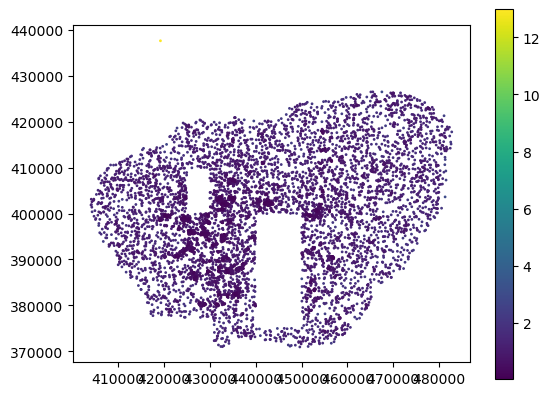

In [30]:
activity = groups["activity_type"][0]
latin_name = groups["latin_name"][5]
print(f"Training model for {latin_name} - {activity}")

presence = bats_ant[
    (bats_ant.latin_name == latin_name) & (bats_ant.activity_type == activity)
]
# Filter to the grid
presence = filter_gdf_to_grid(presence, grid_points)

# Keep only the geometry
presence = presence[ev_columns + ["geometry"]]
background = background[ev_columns + ["geometry"]]

# Drop Missing Values
presence.dropna(inplace=True)
background.dropna(inplace=True)

# Calculate sample weights
presence["sample_weight"] = distance_weights(presence, n_neighbors=5)
background["sample_weight"] = distance_weights(background, n_neighbors=5)

# Print a summary of the number of points
print(f"Presence points: {len(presence)}")
print(f"Background points: {len(background)}")

occurrence = ela.stack_geodataframes(
    presence,
    background,
    add_class_label=True,
)


occurrence.plot("sample_weight", legend=True, markersize=1)

In [31]:
# initialize and print the model defaults
from pprint import pprint

maxent = ela.MaxentModel()
pprint(maxent.get_params())

model = Pipeline(
    [
     #   ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("maxent", MaxentModel(
            feature_types = ["linear"]
        )),
    ]
)

{'beta_categorical': 1.0,
 'beta_hinge': 1.0,
 'beta_lqp': 1.0,
 'beta_multiplier': 1.5,
 'beta_threshold': 1.0,
 'clamp': True,
 'class_weights': 100,
 'convergence_tolerance': 2e-06,
 'feature_types': ['linear', 'hinge', 'product'],
 'n_cpus': 10,
 'n_hinge_features': 10,
 'n_lambdas': 100,
 'n_threshold_features': 10,
 'scorer': 'roc_auc',
 'tau': 0.5,
 'transform': 'cloglog',
 'use_lambdas': 'best',
 'use_sklearn': True}


In [32]:
import numpy as np
import matplotlib.pyplot as plt
test_dfs = []
auc_scores = []

# split the train / test data
fold = 0
n_splits = 3
gfolds = ela.GeographicKFold(n_splits=n_splits)

for train_idx, test_idx in gfolds.split(occurrence):
    # this returns arrays for indexing the original dataframe
    # which requires using the pandas .iloc interface
    train_df = occurrence.iloc[train_idx]
    test_df = occurrence.iloc[test_idx]
    
    X_train = train_df.drop(columns=["class", "sample_weight", "geometry"])
    y_train = train_df["class"]
    sample_weight_train = train_df["sample_weight"]
    
    X_test = test_df.drop(columns=["class", "sample_weight", "geometry"])
    y_test = test_df["class"]
    sample_weight_test = test_df["sample_weight"]

    print(f"Train {X_train.shape}, test {X_test.shape}")
    model.fit(X_train, y_train, maxent__sample_weight=sample_weight_train)
    # evaluation
    ypred = model.predict(X_test)
    auc = f"{roc_auc_score(y_test, ypred):0.3f}"
    auc_scores.append(auc)

    
print(f"{n_splits}-fold xval AUC scores: {', '.join(auc_scores)}")


/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Train (4698, 31), test (2362, 31)
Train (5493, 31), test (1567, 31)
Train (3929, 31), test (3131, 31)
3-fold xval AUC scores: 0.691, 0.918, 0.830


In [33]:
# Male some predictions
path_predict = Path("data/sdm_predictions/temp/test.tif")
ela.apply_model_to_rasters(
    model, 
    temp_ev_raster.name,
    output_path = path_predict

)

Window:   0%|                              | 0/563 [00:00<?, ?it/s]

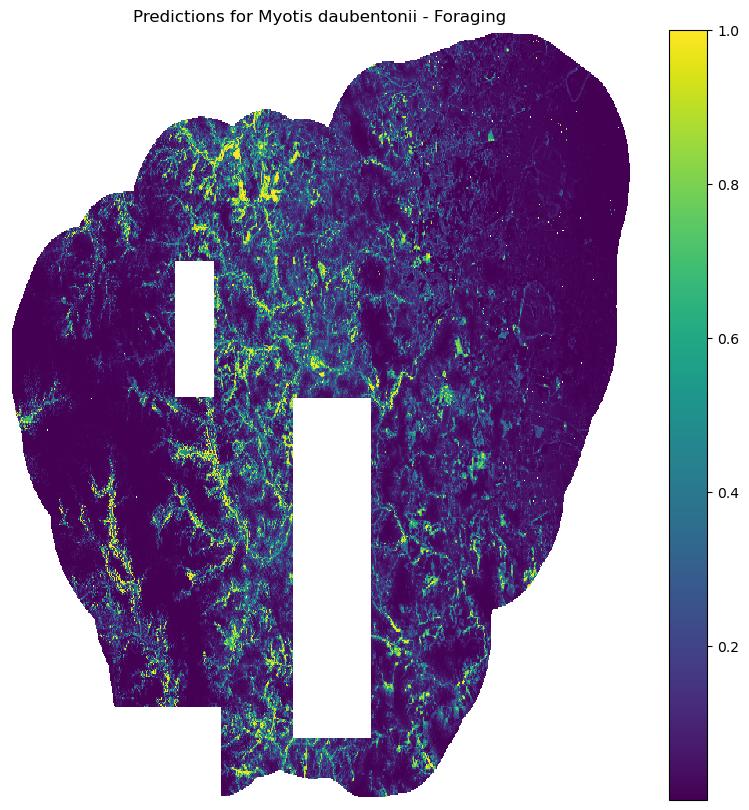

In [34]:
predictions = rxr.open_rasterio(path_predict)
# plot 
fig, ax = plt.subplots(figsize=(10, 10))
predictions.plot(ax=ax, cmap="viridis")
ax.set_axis_off()
ax.set_title(f"Predictions for {latin_name} - {activity}")
plt.show()